# **SMART MOBILE PHONE PRICE PREDICTION**

Downloading the necessary packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import regex as re
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

import warnings
# Settings the warnings to be ignored
warnings.filterwarnings('ignore')

Importing the Dataset

In [288]:
df = pd.read_csv('/kaggle/input/mobile-price-prediction/Processed_Flipdata.csv')

In [289]:
df.shape

(541, 12)

In [290]:
df.head()

Unnamed: 0            Model        Colour  Memory  RAM  Battery_  \
0           0  Infinix SMART 7   Night Black      64    4      6000   
1           1  Infinix SMART 7    Azure Blue      64    4      6000   
2           2     MOTOROLA G32  Mineral Gray     128    8      5000   
3           3         POCO C50    Royal Blue      32    2      5000   
4           4  Infinix HOT 30i      Marigold     128    8      5000   

  Rear Camera Front Camera  AI Lens  Mobile Height  \
0        13MP          5MP        1          16.76   
1        13MP          5MP        1          16.76   
2        50MP         16MP        0          16.64   
3         8MP          5MP        0          16.56   
4        50MP          5MP        1          16.76   

                   Processor_   Prize  
0  Unisoc Spreadtrum SC9863A1   7,299  
1  Unisoc Spreadtrum SC9863A1   7,299  
2     Qualcomm Snapdragon 680  11,999  
3          Mediatek Helio A22   5,649  
4                         G37   8,999

In [291]:
df.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 541 entries, 0 to 540

Data columns (total 12 columns):

 #   Column         Non-Null Count  Dtype  

---  ------         --------------  -----  

 0   Unnamed: 0     541 non-null    int64  

 1   Model          541 non-null    object 

 2   Colour         541 non-null    object 

 3   Memory         541 non-null    int64  

 4   RAM            541 non-null    int64  

 5   Battery_       541 non-null    int64  

 6   Rear Camera    541 non-null    object 

 7   Front Camera   541 non-null    object 

 8   AI Lens        541 non-null    int64  

 9   Mobile Height  541 non-null    float64

 10  Processor_     541 non-null    object 

 11  Prize          541 non-null    object 

dtypes: float64(1), int64(5), object(6)

memory usage: 50.8+ KB


In [292]:
df.isnull().sum()

Unnamed: 0       0
Model            0
Colour           0
Memory           0
RAM              0
Battery_         0
Rear Camera      0
Front Camera     0
AI Lens          0
Mobile Height    0
Processor_       0
Prize            0
dtype: int64

In [293]:
df.columns

Index(['Unnamed: 0', 'Model', 'Colour', 'Memory', 'RAM', 'Battery_',
       'Rear Camera', 'Front Camera', 'AI Lens', 'Mobile Height', 'Processor_',
       'Prize'],
      dtype='object')

Cleaning and Pre-Processing the Data

In [294]:
class Modify_Dataset():

  def __init__(self,data):
    self.data = data
    self.data["Brand"] = None
    self.data["secondary camera"] = None
    self.data["primary camera"] = None
    self.data["price"] = None
    self.data["Price_class"] = None

  def create_brand(self):
    data = self.data
    for i in range(len(data)):
      x = data.loc[i, "Model"]
      brand=list(x.split())
      data["Brand"][i] = brand[0]
    self.data = data
    return self.data

  def camera(self):
    data = self.data
    for i in range(len(data)):
      xval = data.loc[i, "Front Camera"]
      sec=list(xval.split("M"))
      data["secondary camera"][i] = sec[0]
    for i in range(len(data)):
      x = data.loc[i, "Rear Camera"]
      pri=list(x.split("M"))
      data["primary camera"][i] = pri[0]
    self.data = data

  def price(self):
    data = self.data
    for i in range(len(data)):
      x_price = data.loc[i, "Prize"]
      pri=list(x_price.split(','))
      if len(pri)>1:
        data["price"][i] = pri[0]+pri[1]
      else:
        data['price'][i]=pri[0]

  def price_range(self):
    data = self.data
    for i in range(len(data)):
      x = data.loc[i, "price"]
      val = round(data["price"][i],-3)
      data["Price_class"][i] = (val//1000)

  def modify_type(self):
    data = self.data
    data['Memory']=data['Memory'].astype(int)
    data['primary camera']=data['primary camera'].astype(int)
    data['secondary camera']=data['secondary camera'].astype(int)
    data['price']=data['price'].astype(int)


  def finalize_data(self):
    self.create_brand()
    self.camera()
    self.price()
    #self.price_range()
    self.modify_type()
    self.data = self.data[["Brand","Model","Colour","Memory","RAM","Battery_","Rear Camera","Front Camera","primary camera","secondary camera","AI Lens","Mobile Height","Processor_","Prize","price"]]
    return self.data

In [295]:
data = Modify_Dataset(df).finalize_data()
old_dat=data
data

Brand                  Model          Colour  Memory  RAM  Battery_  \
0     Infinix        Infinix SMART 7     Night Black      64    4      6000   
1     Infinix        Infinix SMART 7      Azure Blue      64    4      6000   
2    MOTOROLA           MOTOROLA G32    Mineral Gray     128    8      5000   
3        POCO               POCO C50      Royal Blue      32    2      5000   
4     Infinix        Infinix HOT 30i        Marigold     128    8      5000   
..        ...                    ...             ...     ...  ...       ...   
536   SAMSUNG  SAMSUNG Galaxy S23 5G           Cream     256    8      3900   
537      LAVA               LAVA Z21            Cyan      32    2      3100   
538     Tecno         Tecno Spark 8T  Turquoise Cyan      64    4      5000   
539   SAMSUNG  SAMSUNG Galaxy A54 5G    Awesome Lime     128    8      5000   
540      OPPO               OPPO A77        Sky Blue     128    4      5000   

    Rear Camera Front Camera  primary camera  secondary camera  AI Lens  \
0          13MP          5MP              13                 5        1   
1          13MP          5MP              13                 5        1   
2          50MP         16MP              50                16        0   
3           8MP          5MP               8                 5        0   
4          50MP          5MP              50                 5        1   
..          ...          ...             ...               ...      ...   
536        50MP         12MP              50                12        0   
537         5MP          2MP               5                 2        0   
538        50MP          8MP              50                 8        0   
539        50MP         32MP              50                32        0   
540        50MP          8MP              50                 8        0   

     Mobile Height                   Processor_   Prize  price  
0            16.76   Unisoc Spreadtrum SC9863A1   7,299   7299  
1            16.76   Unisoc Spreadtrum SC9863A1   7,299   7299  
2            16.64      Qualcomm Snapdragon 680  11,999  11999  
3            16.56           Mediatek Helio A22   5,649   5649  
4            16.76                          G37   8,999   8999  
..             ...                          ...     ...    ...  
536          15.49  Qualcomm Snapdragon 8 Gen 2  79,999  79999  
537          12.70                    Octa Core   5,998   5998  
538          16.76           MediaTek Helio G35   9,990   9990  
539          16.26      Exynos 1380, Octa Core   38,999  38999  
540          16.66           Mediatek Helio G35  15,999  15999  

[541 rows x 15 columns]

In [296]:
data.isnull().sum()

Brand               0
Model               0
Colour              0
Memory              0
RAM                 0
Battery_            0
Rear Camera         0
Front Camera        0
primary camera      0
secondary camera    0
AI Lens             0
Mobile Height       0
Processor_          0
Prize               0
price               0
dtype: int64

In [297]:
data.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 541 entries, 0 to 540

Data columns (total 15 columns):

 #   Column            Non-Null Count  Dtype  

---  ------            --------------  -----  

 0   Brand             541 non-null    object 

 1   Model             541 non-null    object 

 2   Colour            541 non-null    object 

 3   Memory            541 non-null    int64  

 4   RAM               541 non-null    int64  

 5   Battery_          541 non-null    int64  

 6   Rear Camera       541 non-null    object 

 7   Front Camera      541 non-null    object 

 8   primary camera    541 non-null    int64  

 9   secondary camera  541 non-null    int64  

 10  AI Lens           541 non-null    int64  

 11  Mobile Height     541 non-null    float64

 12  Processor_        541 non-null    object 

 13  Prize             541 non-null    object 

 14  price             541 non-null    int64  

dtypes: float64(1), int64(7), object(7)

memory usage: 63.5+ KB


### **EXPLORATORY DATA ANALYSIS (EDA)**

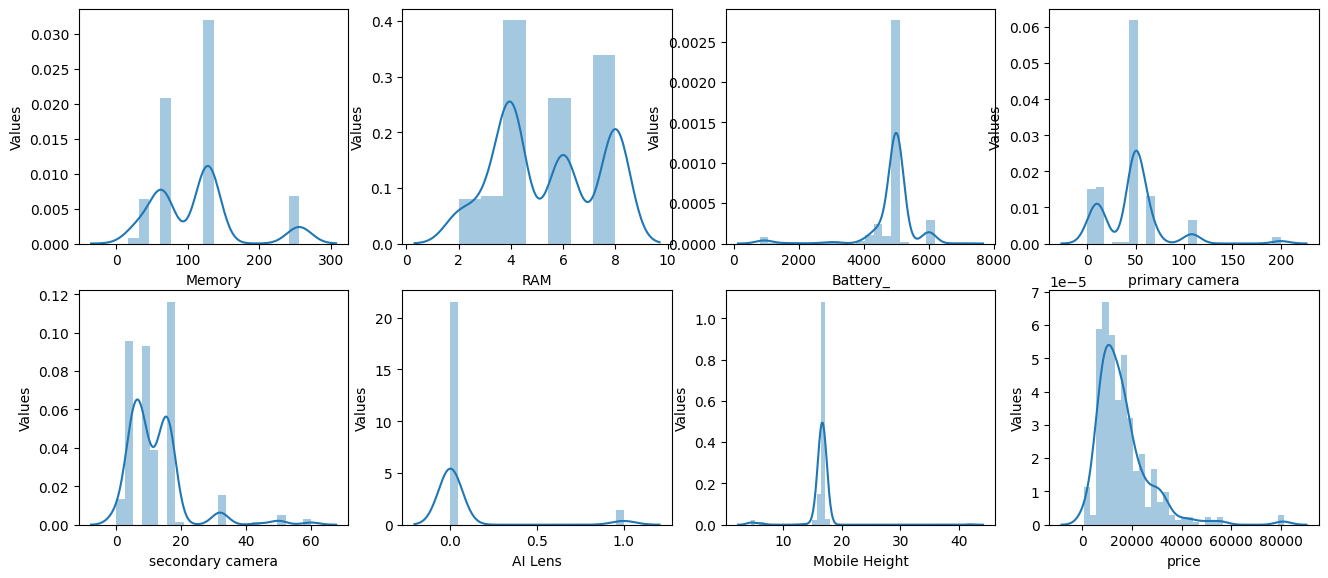

In [298]:
plt.figure(figsize=(16,14))
plotnumber=1
df1 = data.drop(columns=['Model', 'Colour',
       'Rear Camera', 'Front Camera', 'Processor_',
       'Prize','Brand'])
for column in df1:
    if plotnumber <12:
        ax=plt.subplot(4,4,plotnumber)
        sns.distplot(df1[column])
        plt.xlabel(column,fontsize=10)
        plt.ylabel('Values',fontsize=10)
    plotnumber+=1
plt.show()

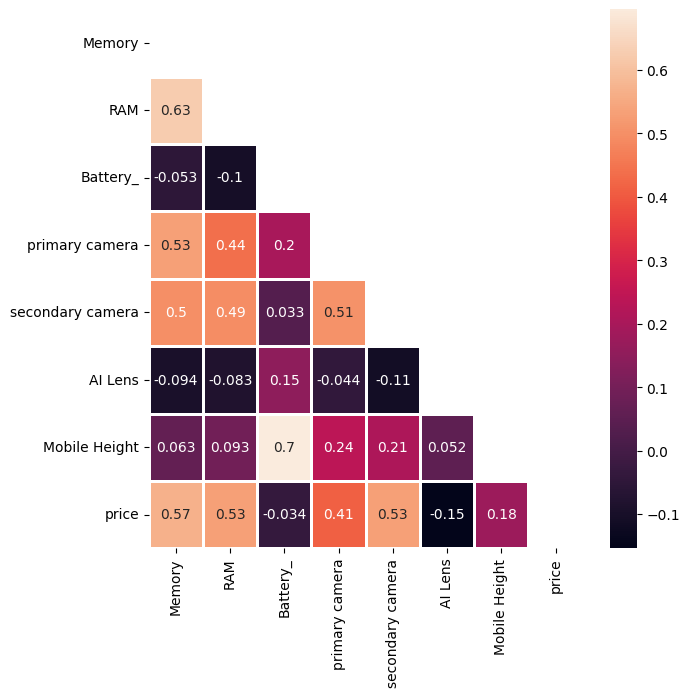

In [299]:
plt.figure(figsize = (7,7))

corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))
sns.heatmap(corr, mask = mask, annot = True, fmt = '.2g', linewidths = 1)
plt.show()

**Frequency of** **Price**

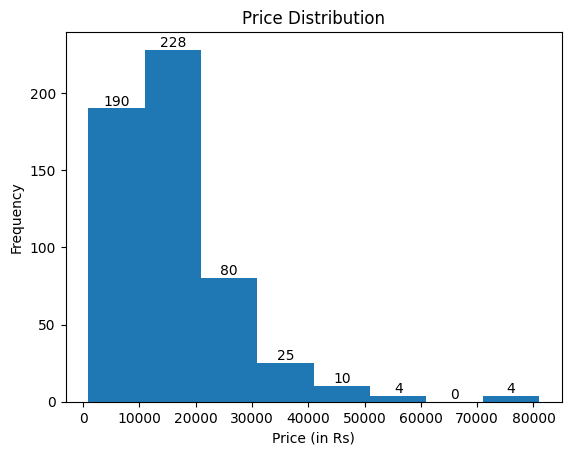

In [300]:
n, bins, patches = plt.hist(df['price'], bins = 8)

plt.xlabel('Price (in Rs)')
plt.ylabel('Frequency')
plt.title('Price Distribution')

for i in range(len(patches)):
    x = bins[i]
    y = n[i]
    plt.annotate(str(int(y)), xy=(x + (bins[i+1] - bins[i])/2, y), ha='center', va='bottom')

plt.show()

Upon examining the graph, it is evident that a significant majority of mobile phone prices fall within the range of below 20,000Rs. We will now delve deeper into the analysis of the price distribution within this specific range.

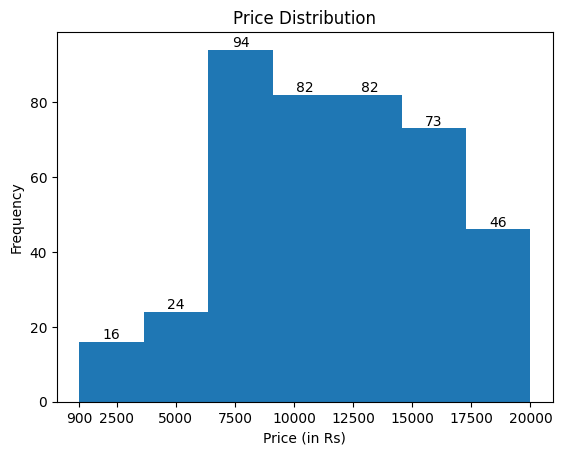

In [301]:
_price = df.loc[df['price'] < 20000, 'price']
n, bins, patches = plt.hist(_price, bins = 7)

plt.xlabel('Price (in Rs)')
plt.ylabel('Frequency')
plt.title('Price Distribution')
plt.xticks([900,2500,5000,7500,10000,12500,15000,17500,20000])

for i in range(len(patches)):
    x = bins[i]
    y = n[i]
    plt.annotate(str(int(y)), xy=(x + (bins[i+1] - bins[i])/2, y), ha='center', va='bottom')

plt.show()

In [302]:
data=data.drop(columns=['Model', 'Rear Camera', 'Front Camera','Prize'],axis=1)

In [303]:
data.shape

(541, 11)

In [304]:
data.var()

Memory              3.672444e+03
RAM                 3.939919e+00
Battery_            6.086322e+05
primary camera      9.772136e+02
secondary camera    8.197032e+01
AI Lens             5.900596e-02
Mobile Height       6.368318e+00
price               1.165015e+08
dtype: float64

In the dataset, the price of mobile phones are represented as numerical values.

For example, if the actual price of a mobile phone was 14,999 and the model predicted the price to be 14,059, the mean squared error (MSE) would be calculated as (14,999 - 14,059)², resulting in a relatively large value of 940² = 883600.

Due to the discrepancy between the predicted and actual values, the MSE might not provide an accurate representation of the model's performance.

To address this issue and simplify the evaluation process, a new column called "Price_Class" is introduced.

 The price of each mobile phone was rounded off to the nearest thousand. For instance, the price of 14,999 was rounded off to 15,000. The rounded-off value was then divided by 1,000, resulting in a new value of 15.

**By introducing this rounding and dividing technique, the price values were grouped into broader classes, reducing the sensitivity to exact price predictions.**

### **MODEL TRAINING AND EVALUATION**

In [305]:
data["Price_class"] = None
for i in range(len(data)):
  x = data.loc[i, "price"]
  val = round(data["price"][i],-3)
  data["Price_class"][i] = (val//1000)

In [306]:
X=data.drop(columns=['price','Colour','Price_class','AI Lens'],axis=1)
y=data[['price','Price_class']]

In [307]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

categorical_features = []
for col, value in X.items():
    if value.dtype == 'object':
        categorical_features.append(col)

for col in categorical_features:
    X[col] = le.fit_transform(X[col])

X.head()

Brand  Memory  RAM  Battery_  primary camera  secondary camera  \
0      4      64    4      6000              13                 5   
1      4      64    4      6000              13                 5   
2      6     128    8      5000              50                16   
3     11      32    2      5000               8                 5   
4      4     128    8      5000              50                 5   

   Mobile Height  Processor_  
0          16.76         113  
1          16.76         113  
2          16.64          75  
3          16.56          56  
4          16.76          14

In [308]:
X.columns

Index(['Brand', 'Memory', 'RAM', 'Battery_', 'primary camera',
       'secondary camera', 'Mobile Height', 'Processor_'],
      dtype='object')

In [309]:
y

price Price_class
0     7299           7
1     7299           7
2    11999          12
3     5649           6
4     8999           9
..     ...         ...
536  79999          80
537   5998           6
538   9990          10
539  38999          39
540  15999          16

[541 rows x 2 columns]

In [310]:
X.describe()

Brand      Memory         RAM     Battery_  primary camera  \
count  541.000000  541.000000  541.000000   541.000000      541.000000   
mean    12.983364  110.550832    5.397412  4871.587800       46.110906   
std      6.323509   60.600694    1.984923   780.148862       31.260416   
min      0.000000   16.000000    2.000000   800.000000        0.000000   
25%      8.000000   64.000000    4.000000  5000.000000       13.000000   
50%     12.000000  128.000000    6.000000  5000.000000       50.000000   
75%     20.000000  128.000000    8.000000  5000.000000       50.000000   
max     22.000000  256.000000    8.000000  7000.000000      200.000000   

       secondary camera  Mobile Height  Processor_  
count        541.000000     541.000000  541.000000  
mean          11.992606      16.431201   61.528651  
std            9.053746       2.523553   32.456318  
min            0.000000       4.500000    0.000000  
25%            5.000000      16.510000   40.000000  
50%            8.000000      16.710000   59.000000  
75%           16.000000      16.940000   83.000000  
max           60.000000      41.940000  122.000000

In [311]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,random_state=5)

In [312]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>

Int64Index: 378 entries, 351 to 206

Data columns (total 8 columns):

 #   Column            Non-Null Count  Dtype  

---  ------            --------------  -----  

 0   Brand             378 non-null    int64  

 1   Memory            378 non-null    int64  

 2   RAM               378 non-null    int64  

 3   Battery_          378 non-null    int64  

 4   primary camera    378 non-null    int64  

 5   secondary camera  378 non-null    int64  

 6   Mobile Height     378 non-null    float64

 7   Processor_        378 non-null    int64  

dtypes: float64(1), int64(7)

memory usage: 26.6 KB


In [313]:
X_test

Brand  Memory  RAM  Battery_  primary camera  secondary camera  \
281     20      32    2      5000               8                 5   
40       6      64    4      5000              50                 8   
404      3     128    8      5000              64                16   
457     10     128    6      4300              48                16   
223      4     128    8      5000              50                16   
..     ...     ...  ...       ...             ...               ...   
452     12     128    6      5000             108                16   
373      4      64    2      5000               8                 5   
485      4      64    6      5000              50                 8   
122      4      64    2      5000               8                 5   
9        4      64    4      5000              50                 5   

     Mobile Height  Processor_  
281          16.51         100  
40           16.51          58  
404          17.22         105  
457          16.64          94  
223          17.22          52  
..             ...         ...  
452          16.33          49  
373          16.76          56  
485          16.76         118  
122          16.76         107  
9            16.76          14  

[163 rows x 8 columns]

In [314]:
y_train

price Price_class
351   9349           9
357  18999          19
440  27999          28
383   9499           9
101  15999          16
..     ...         ...
8     7999           8
73    6299           6
400  49999          50
118   1299           1
206  17499          17

[378 rows x 2 columns]

In [315]:
y_test

price Price_class
281   6978           7
40    7999           8
404  30385          30
457  29790          30
223  15999          16
..     ...         ...
452  16990          17
373   6999           7
485   9999          10
122   6199           6
9     7999           8

[163 rows x 2 columns]

## **MODEL TRAINING**

**RANDOM FOREST ALGORITHM**

In [316]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(n_estimators=100, random_state=42)
RF.fit(X_train, y_train["price"])
y_pred = RF.predict(X_test)

y_pred_class = []
for i in range(len(y_pred)):
  val = round(y_pred[i],-3)
  y_pred_class.append(val//1000)



In [317]:
y_test = y_test["Price_class"].tolist()
print(len(y_test),len(y_pred_class))

163 163


<Axes: >

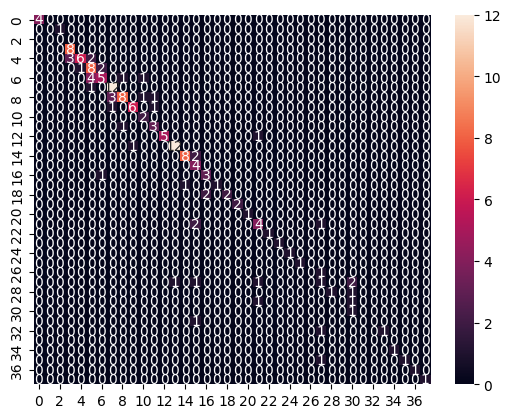

In [318]:
cm_rf = confusion_matrix(y_test, y_pred_class)
sns.heatmap(cm_rf, annot=True, fmt='d')

In [319]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

acc_rf = accuracy_score(y_test, y_pred_class)
print("Accuracy of Random Forest: ", acc_rf)
r2_rf = r2_score(y_test, y_pred_class)
print('R-squared score:', r2_rf)
mse_rf = mean_squared_error(y_test, y_pred_class)
print('Mean Squared Error:', mse_rf)

Accuracy of Random Forest:  0.7055214723926381

R-squared score: 0.9147152815893551

Mean Squared Error: 10.012269938650308


**RANDOM FOREST REGRESSOR**

In [320]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:



{'bootstrap': True,

 'ccp_alpha': 0.0,

 'criterion': 'squared_error',

 'max_depth': None,

 'max_features': 1.0,

 'max_leaf_nodes': None,

 'max_samples': None,

 'min_impurity_decrease': 0.0,

 'min_samples_leaf': 1,

 'min_samples_split': 2,

 'min_weight_fraction_leaf': 0.0,

 'n_estimators': 100,

 'n_jobs': None,

 'oob_score': False,

 'random_state': 42,

 'verbose': 0,

 'warm_start': False}


In [321]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],

 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],

 'max_features': ['auto', 'sqrt'],

 'min_samples_leaf': [1, 2, 4],

 'min_samples_split': [2, 5, 10],

 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [322]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

rf_random.fit(X_train,y_train["price"])
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [323]:
y_pred = rf_random.predict(X_test)

y_pred_class = []
for i in range(len(y_pred)):
  val = round(y_pred[i],-3)
  y_pred_class.append(val//1000)

In [324]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

acc_rfr = accuracy_score(y_test, y_pred_class)
print("Accuracy of Random Forest: ", acc_rfr)
r2_rfr = r2_score(y_test, y_pred_class)
print('R-squared score:', r2_rfr)
mse_rfr = mean_squared_error(y_test, y_pred_class)
print('Mean Squared Error:', mse_rfr)

Accuracy of Random Forest:  0.6993865030674846

R-squared score: 0.9319603533268016

Mean Squared Error: 7.987730061349693


**DECISION TREE**

In [325]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train,  y_train["price"])
y_pred = dt.predict(X_test)

y_pred_class = []
for i in range(len(y_pred)):
  val = round(y_pred[i],-3)
  y_pred_class.append(val//1000)

<Axes: >

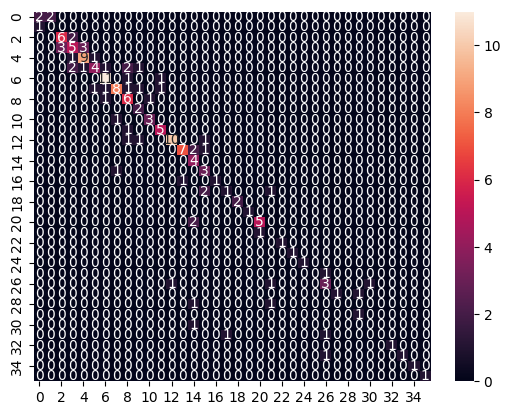

In [326]:
cm_rf = confusion_matrix(y_test, y_pred_class)
sns.heatmap(cm_rf, annot=True, fmt='d')

In [327]:
acc_dt = accuracy_score(y_test, y_pred_class)
print("Accuracy of Decision Tree: ", acc_dt)
r2_dt = r2_score(y_test, y_pred_class)
print('R-squared score:', r2_dt)
mse_dt = mean_squared_error(y_test, y_pred_class)
print('Mean Squared Error:', mse_dt)

Accuracy of Decision Tree:  0.656441717791411

R-squared score: 0.8987243968873592

Mean Squared Error: 11.889570552147239


**KNN**

In [328]:
import pandas as pd
import numpy as np

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train["price"])
y_pred = knn.predict(X_test)

y_pred_class = []
for i in range(len(y_pred)):
  val = round(y_pred[i],-3)
  y_pred_class.append(val//1000)

<Axes: >

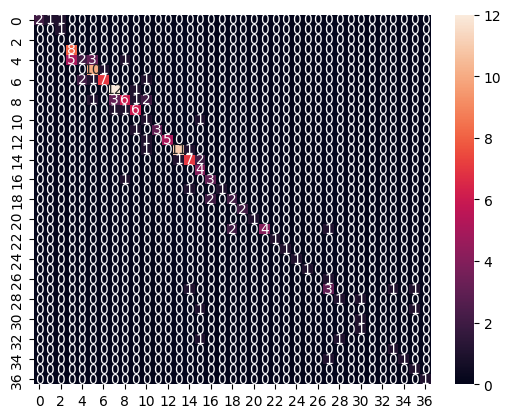

In [329]:
cm_rf = confusion_matrix(y_test, y_pred_class)
sns.heatmap(cm_rf, annot=True, fmt='d')

In [330]:
acc_knn = accuracy_score(y_test, y_pred_class)
print("Accuracy of knn: ", acc_knn)
r2_knn = r2_score(y_test, y_pred_class)
print('R-squared score:', r2_knn)
mse_knn = mean_squared_error(y_test, y_pred_class)
print('Mean Squared Error:', mse_knn)

Accuracy of knn:  0.6748466257668712

R-squared score: 0.84354016732753

Mean Squared Error: 18.368098159509202


**LINEAR DISCRIMINANT ANALYSIS**

In [331]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


model = LinearDiscriminantAnalysis()
model.fit(X_train, y_train["price"])
y_pred = model.predict(X_test)

<Axes: >

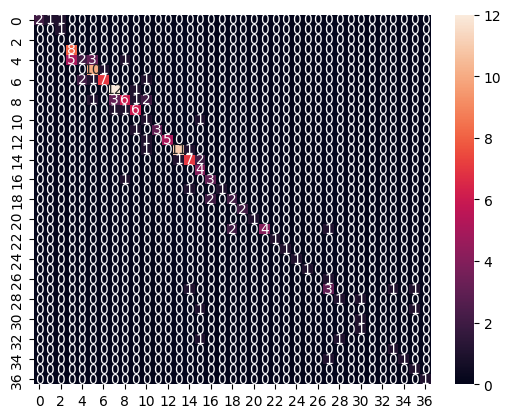

In [332]:
cm_rf = confusion_matrix(y_test, y_pred_class)
sns.heatmap(cm_rf, annot=True, fmt='d')

In [333]:
acc_lda = accuracy_score(y_test, y_pred_class)
print("Accuracy of knn: ", acc_lda)
r2_lda = r2_score(y_test, y_pred_class)
print('R-squared score:', r2_lda)
mse_lda = mean_squared_error(y_test, y_pred_class)
print('Mean Squared Error:', mse_lda)

Accuracy of knn:  0.6748466257668712

R-squared score: 0.84354016732753

Mean Squared Error: 18.368098159509202


**GAUSSIAN NAIVE BAYES**

In [334]:
import pandas as pd
import numpy as np

from sklearn.naive_bayes import GaussianNB

NB= GaussianNB()
NB.fit(X_train, y_train["price"])
y_pred = NB.predict(X_test)

y_pred_class = []
for i in range(len(y_pred)):
  val = round(y_pred[i],-3)
  y_pred_class.append(val//1000)

<Axes: >

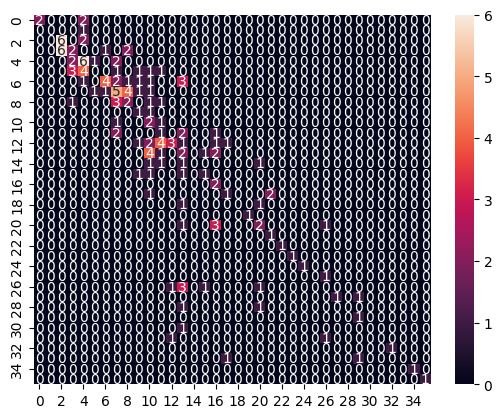

In [335]:
cm_rf = confusion_matrix(y_test, y_pred_class)
sns.heatmap(cm_rf, annot=True, fmt='d')

In [336]:
r2_GNB = r2_score(y_test, y_pred_class)
print('R-squared score:', r2_GNB)
mse_GNB = mean_squared_error(y_test, y_pred_class)
print('Mean Squared Error:', mse_GNB)

R-squared score: 0.7722082796862737

Mean Squared Error: 26.742331288343557


**LOGISTIC REGRESSION**

In [337]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression


clf = LogisticRegression()
clf.fit(X_train, y_train["price"])

y_pred = clf.predict(X_test)

y_pred_class = []
for i in range(len(y_pred)):
  val = round(y_pred[i],-3)
  y_pred_class.append(val//1000)

<Axes: >

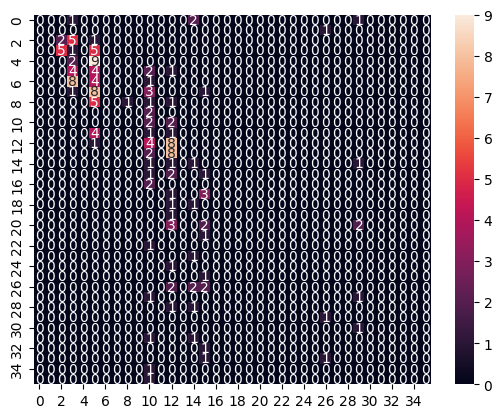

In [338]:
cm_rf = confusion_matrix(y_test, y_pred_class)
sns.heatmap(cm_rf, annot=True, fmt='d')

In [339]:
r2_lr = r2_score(y_test, y_pred_class)
print('R-squared score:', r2_lr)
mse_lr = mean_squared_error(y_test, y_pred_class)
print('Mean Squared Error:', mse_lr)

R-squared score: 0.1888545348222851

Mean Squared Error: 95.22699386503068


**SUPPORT VECTOR MACHINE**

In [340]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, y_train["price"])

SVC()

<Axes: >

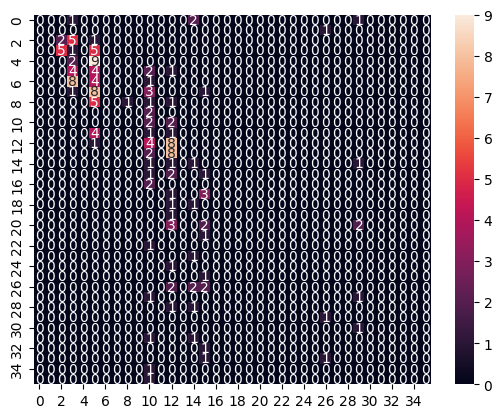

In [341]:
cm_rf = confusion_matrix(y_test, y_pred_class)
sns.heatmap(cm_rf, annot=True, fmt='d')

In [342]:
r2_svm = r2_score(y_test, y_pred_class)
print('R-squared score:', r2_svm)
mse_svm = mean_squared_error(y_test, y_pred_class)
print('Mean Squared Error:', mse_svm)

R-squared score: 0.1888545348222851

Mean Squared Error: 95.22699386503068


**STOCHASTIC GRADIENT DESCENT**

In [343]:
from sklearn.linear_model import SGDClassifier
sdg = SGDClassifier(loss="hinge", penalty="l2", max_iter=5)

sdg.fit(X_train, y_train["price"])
y_pred = sdg.predict(X_test)

y_pred_class = []
for i in range(len(y_pred)):
  val = round(y_pred[i],-3)
  y_pred_class.append(val//1000)

<Axes: >

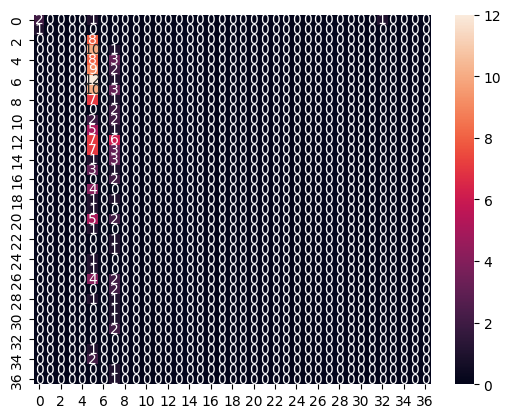

In [344]:
cm_rf = confusion_matrix(y_test, y_pred_class)
sns.heatmap(cm_rf, annot=True, fmt='d')

In [345]:
r2_sgd = r2_score(y_test, y_pred_class)
print('R-squared score:', r2_sgd)
mse_sgd = mean_squared_error(y_test, y_pred_class)
print('Mean Squared Error:', mse_sgd)

R-squared score: -0.38206185527348446

Mean Squared Error: 162.25153374233128


### **COMPARE AND CONTRAST ALGORITHMS**

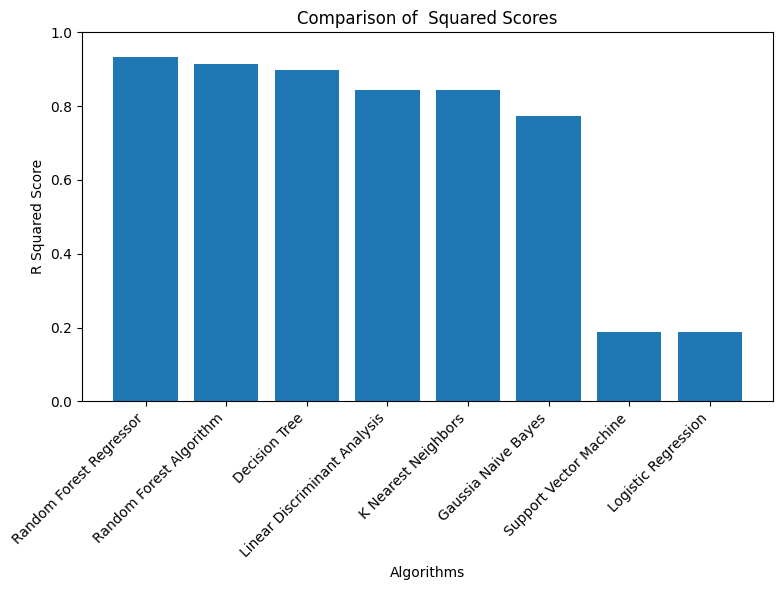

In [347]:
import matplotlib.pyplot as plt

algorithms = ["Random Forest Algorithm","Random Forest Regressor","Decision Tree","K Nearest Neighbors","Linear Discriminant Analysis","Gaussia Naive Bayes","Logistic Regression","Support Vector Machine"]
r2_values = [r2_rf, r2_rfr, r2_dt, r2_knn, r2_lda, r2_GNB, r2_lr, r2_svm ]

# Sort the algorithms and accuracy values based on accuracy values
sorted_data = sorted(zip(r2_values, algorithms),reverse = True)
r2_values, algorithms = zip(*sorted_data)

# Plotting the graph
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(algorithms, r2_values)
ax.set_xlabel('Algorithms')
ax.set_ylabel('R Squared Score')
ax.set_title('Comparison of  Squared Scores')
ax.set_ylim(0, 1)

plt.xticks(rotation=45, ha='right')

plt.tight_layout()

plt.show()

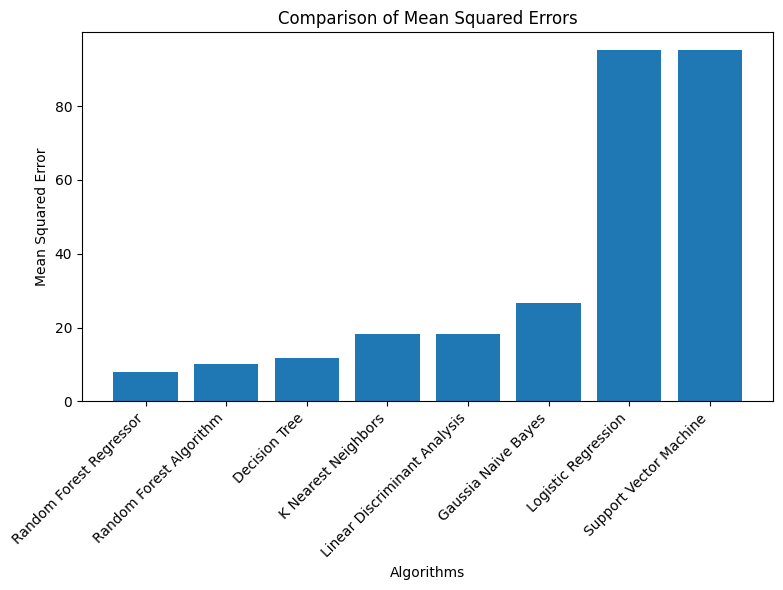

In [348]:
import matplotlib.pyplot as plt

algorithms = ["Random Forest Algorithm","Random Forest Regressor","Decision Tree","K Nearest Neighbors","Linear Discriminant Analysis","Gaussia Naive Bayes","Logistic Regression","Support Vector Machine"]
mse_values = [mse_rf, mse_rfr, mse_dt, mse_knn, mse_lda, mse_GNB, mse_lr, mse_svm ]

# Sorting the algorithms and accuracy values based on accuracy values
sorted_data = sorted(zip(mse_values, algorithms))
mse_values, algorithms = zip(*sorted_data)

# Plotting the graph
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(algorithms, mse_values)
ax.set_xlabel('Algorithms')
ax.set_ylabel('Mean Squared Error')
ax.set_title('Comparison of Mean Squared Errors')

plt.xticks(rotation=45, ha='right')

plt.tight_layout()

plt.show()

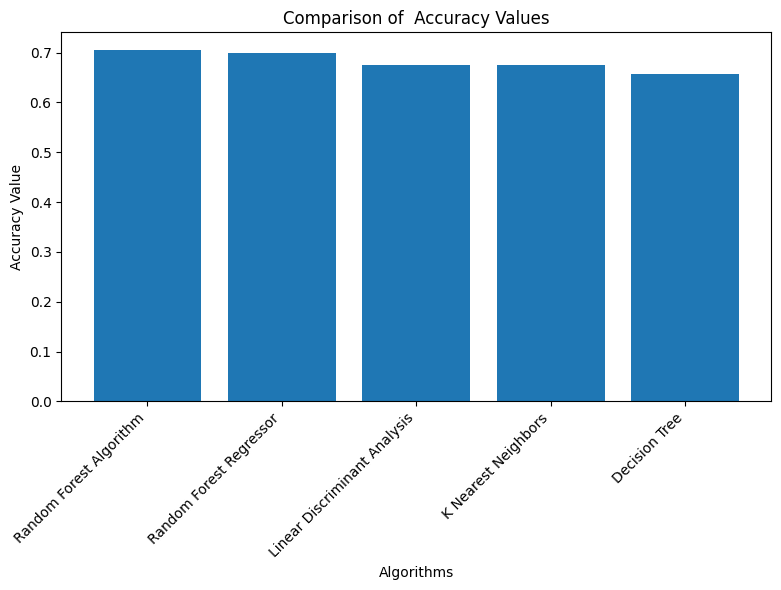

In [349]:
import matplotlib.pyplot as plt

algorithms = ["Random Forest Algorithm","Random Forest Regressor","Decision Tree","K Nearest Neighbors","Linear Discriminant Analysis"]
accuracy_values = [acc_rf, acc_rfr, acc_dt, acc_knn, acc_lda]

# Sort the algorithms and accuracy values based on accuracy values
sorted_data = sorted(zip(accuracy_values, algorithms),reverse = True)
accuracy_values, algorithms = zip(*sorted_data)

# Plotting the graph
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(algorithms, accuracy_values)
ax.set_xlabel('Algorithms')
ax.set_ylabel('Accuracy Value')
ax.set_title('Comparison of  Accuracy Values')

plt.xticks(rotation=45, ha='right')

plt.tight_layout()

plt.show()